# **TextTamer**  

Installing the Necessary Packages

In [4]:
!pip install -q -U langchain langgraph langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00


Setting the ENV keys

In [5]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

Initializing the Model

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
# Initializing the model
model = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash' , api_key=gemini_api_key , temprature = 0.3)


Creating State

In [24]:
from typing_extensions import TypedDict
from typing import Dict
class State(TypedDict):
  text : str
  category : str
  keys : list[str]
  glossary : Dict[str,str]
  summary : str

### **NODES**

In [89]:
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage

#  Classification Node

def Classify(state:State):
   ''' We will Classify the text into one of the categories: News, Blog, Research, or Other '''
   prompt = PromptTemplate(
       input_variables=["text"],
       template = "Classify this text into one of the categories: News, Blog, Research, or if it dont exist in these categories then return the suitable one in a single word , for example like : Blog \n {text}"
   )
   message = HumanMessage(prompt.format(text=state['text']))
   category = model.predict_messages([message]).content.strip()
   return {"category" : category}
#  Keyword Extraction Node

def Keyword(state:State):
   ''' We will Extract Important Entities (Person , Location , Organization etc) from the text  '''
   prompt = PromptTemplate(
       input_variables=["text"],
       template = "Extract no more than 2-3 important terms and difficult or specialized keywords from the  text if the text is of 2 3 lines and if the text is bigger than adjust with this average. Only include uncommon or technical words that might not be widely understood by the general public, and ignore common or general terms.Just Return the terms without any mardown symbols \n\nText:{text}\n\n Important Keywords:"
   )
   message = HumanMessage(prompt.format(text=state['text']))
   keys = model.predict_messages([message]).content.strip().split(', ')
   return {"keys" : keys }
   #  Glossary Node

def Glossary(state:State):
  ''' We will Provide the Glossary of these Entities Extracted Previously '''
  prompt = PromptTemplate(
       input_variables=["keys"], # Changed input_variables to 'keys'
       template = "provide a one liner easy explanation of the each key word in this list /n{keys} , and response in key value pairs like in a dictioanry without any markdown symbols just key values in inverted commas"
  )

  # Accessing keys directly using state['keys']
  message = HumanMessage(prompt.format(keys=state['keys']))
  glossary = model.predict_messages([message]).content.strip() # Assuming the model's response can be split by ', '
  return {"glossary" : glossary }
  #  Summary Node

def Summary(state:State):
  ''' We will Sumarize the text   '''
  prompt = PromptTemplate(
       input_variables=["text"],
       template = "Summarize this text into easy and simple words so that anyone can easily understand\n\nText:{text}\n\n Summary : "
   )
  message = HumanMessage(prompt.format(text=state['text']))
  summary = model.predict_messages([message]).content.strip()
  return {"summary" : summary }

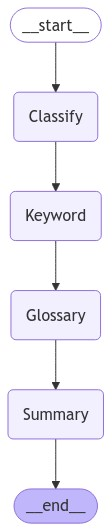

In [90]:
from langgraph.graph import StateGraph , START , END
from IPython.display import display, Image
# Graph
builder = StateGraph(State)
# Nodes
builder.add_node("Classify",Classify)
builder.add_node("Keyword",Keyword)
builder.add_node("Glossary",Glossary)
builder.add_node("Summary",Summary)
# Edges
builder.add_edge(START,"Classify")
builder.add_edge("Classify","Keyword")
builder.add_edge("Keyword","Glossary")
builder.add_edge("Glossary","Summary")
builder.add_edge("Summary",END)
# Compile
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))




In [105]:
sample_text = """
AI has captured the imagination and attention of people globally. But in the business world, the rate of adoption of artificial intelligence has lagged behind the level of interest through 2019. Even though we hear that most business leaders believe AI provides a competitive advantage, up until recently, some industry watchers have pegged enterprise adoption.
"""
state_input = {"text": sample_text}
result = graph.invoke(state_input)
print("Category:", result["category"])
keywords = result['keys']
print ('Important Terms')
for k in keywords:
  print(f"- {k}")
glossary = result['glossary']
print(glossary)
print("\nSummary:\n", result["summary"])


Category: Blog
Important Terms
- Artificial intelligence
- Enterprise adoption
{ 'Artificial intelligence': 'Computers mimicking human intelligence', 'Enterprise adoption': 'Businesses using new technologies'}

Summary:
 Even though everyone is talking about AI, businesses haven't been using it as much as you'd think.  Even though business leaders think AI can help them win, not many companies have actually started using it.
